## Thermoelectrics dataset

These data come from:
Gaultois, M. W. et. al. A data-driven review of thermoelectric materials: Performance and resource considerations. _Chemistry of Materials_ 2013, 25, 15, 2911-2920.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import seaborn as sns

In [72]:
df = pd.read_csv("thermoelectrics_raw.csv")

In [73]:
df

,formula,Crystallinity,Temperature (K),log Resistivity,Power factor (W*m/K^2),ZT,Thermal conductivity (W/(m*K)),Seebeck coefficient (uV/K)
0,Zr$_{0.94}$Y$_{0.06}$NiSn$_{0.96}$Sb$_{0.04}$,polycrystalline,300.000112,-3.112946,0.001100,0.039442,8.35000,-92.0000
1,In$_{1.9}$Ge$_{0.1}$O$_{3}$,polycrystalline,1000.000131,-2.680555,0.000661,0.262892,2.51443,-117.4440
2,Fe$_{0.978}$Co$_{0.00196}$Si$_{1.96}$Y$_{0.12}...,polycrystalline,1000.000171,-1.669586,0.000022,0.006710,3.22000,-68.0000
3,Ca$_{0.9}$Bi$_{0.1}$MnO$_{3}$,polycrystalline,1000.000171,-2.284888,0.000178,0.096460,1.84140,-96.0071
4,Mn$_{1.3}$Mo$_{6}$S$_{8}$,polycrystalline,300.000130,-3.160909,0.000108,0.022592,1.43230,27.2882
...,...,...,...,...,...,...,...,...
683,Ca$_{0.7}$Y$_{0.3}$MnO$_{3}$,polycrystalline,700.000872,-2.202382,0.000044,0.020260,1.51492,-52.4500
684,CaMnO$_{3}$,polycrystalline,1000.000213,-0.956358,0.000150,0.089159,1.67874,-406.8100
685,WO$_{2.9}$,polycrystalline,300.000489,-2.907199,0.000064,0.006251,3.08340,-28.2100
686,WO$_{2.722}$,polycrystalline,400.000598,-4.009425,0.000649,0.033229,7.81700,-25.2100


In [74]:
outputs = {
    "sigma": "log Resistivity",
    "pow": "Power factor (W*m/K^2)",
    "ZT": "ZT",
    "kappa": "Thermal conductivity (W/(m*K))",
    "Seebeck": "Seebeck coefficient (uV/K)"
}

After much slicing of the data I settled on two sets of objectives. The first is to get ZT and Seebeck coefficient above the values 1.5 and 250. There are 3 rows that meet these objectives. Because ZT and Seebeck are correlated in a simple positive way in this region of parameter space, it's a relatively easy problem.
The second set of objectives relaxes ZT to 1.25 and Seebeck coefficient to 175, but requires the power factor to be above 5e-3 and the thermal conductivity to be above 1.5. There is only 1 row that meets these objectives.

In [94]:
ZT_threshold_2 = 1.50
Seebeck_threshold_2 = 250
ZT_threshold_4 = 1.25
Seebeck_threshold_4 = 175
power_threshold_4 = 5e-3
thermal_threshold_4 = 1.5
def promising_candidate(row):
    ZT = row[outputs["ZT"]]
    seebeck = row[outputs["Seebeck"]]
    power_factor = row[outputs["pow"]]
    thermal_cond = row[outputs["kappa"]]
    satisfies2 = ZT >= ZT_threshold_2 and seebeck >= Seebeck_threshold_2
    satisfies4 = ZT >= ZT_threshold_4 and seebeck >= Seebeck_threshold_4 and power_factor >= power_threshold_4 and thermal_cond > thermal_threshold_4
    if satisfies2 and satisfies4:
        return "both"
    elif satisfies2:
        return "2 objectives"
    elif satisfies4:
        return "4 objectives"
    else:
        return "none"
df_objectives = df.copy()
df_objectives['satisfies objectives'] = df.apply(lambda row: promising_candidate(row), axis = 1)

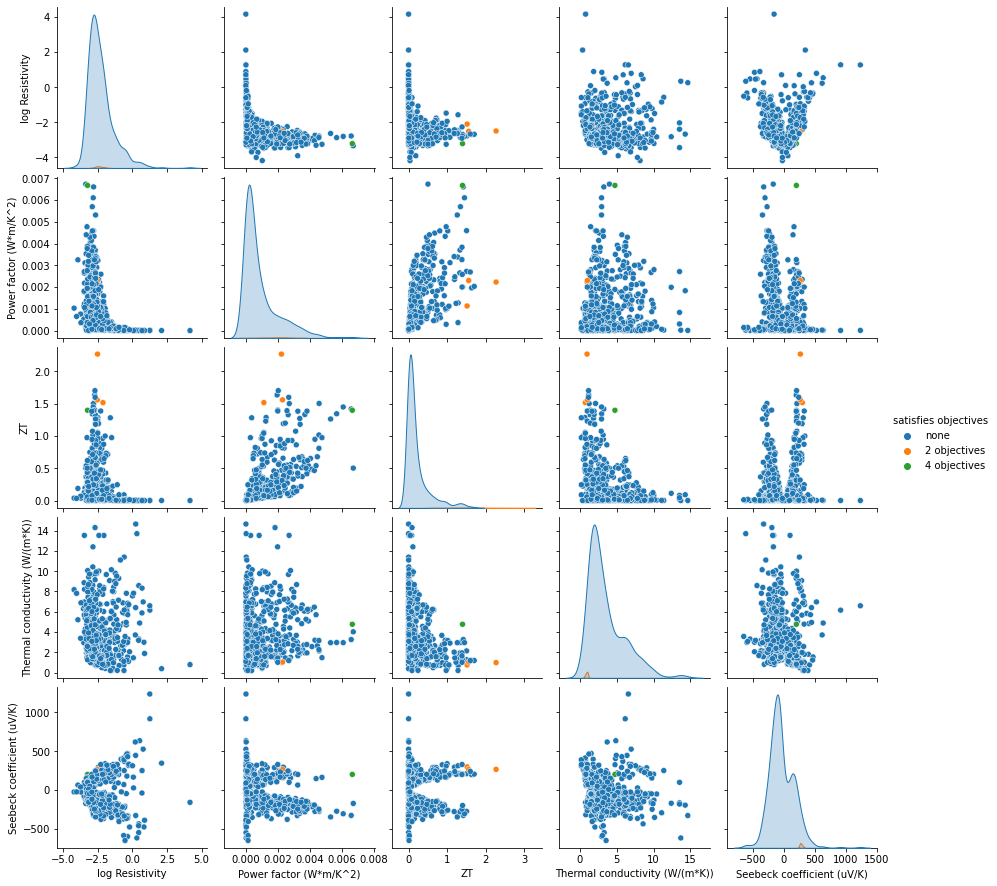

In [95]:
sns.pairplot(df_objectives, vars = list(outputs.values()), hue = "satisfies objectives")

In [97]:
df[df_objectives["satisfies objectives"] == "2 objectives"]

,formula,Crystallinity,Temperature (K),log Resistivity,Power factor (W*m/K^2),ZT,Thermal conductivity (W/(m*K)),Seebeck coefficient (uV/K)
71,Cu$_{2}$Se,polycrystalline,1000.000016,-2.107905,0.00113,1.517966,0.745,297.0
214,Pb$_{0.96}$Sr$_{0.4}$TeNa$_{0.2}$,polycrystalline,1000.000238,-2.501059,0.00223,2.270000,0.980,265.0
494,Pb$_{0.98}$Sr$_{0.2}$TeNa$_{0.1}$,polycrystalline,700.000116,-2.521138,0.00230,1.560000,1.030,263.0


In [98]:
df[df_objectives["satisfies objectives"] == "4 objectives"]

,formula,Crystallinity,Temperature (K),log Resistivity,Power factor (W*m/K^2),ZT,Thermal conductivity (W/(m*K)),Seebeck coefficient (uV/K)
339,NaCo$_{2}$O$_{4}$,single crystal,1000.000269,-3.221849,0.00667,1.399414,4.7639,200.0


In [99]:
# Convert chemical formulae from Latex to stoichiometric, so it can be read by Matminer
# (e.g., $In_{1.9}Ge_{0.1}O_3$ to In1.9Ge0.1O3)
detexified_formulae = [f.translate({ord(c): None for c in '$_{}'}) for f in df["formula"]]
df["formula"] = detexified_formulae

Of the 5 output variables, ZT and Seebeck coefficient have the most clear relationship.
ZT goes as Seebeck^2, but there's also a factor of Temperature (which the model will have access to) and factors of thermal/electrical conductivity (which the model will **not** have access to as they are being treated as outputs).
Overall, it looks like a quadratic relationship with noise. **But** there are also several training points for which ZT = 0 despite large values of the Seebeck coefficient, and these complicated the trend.

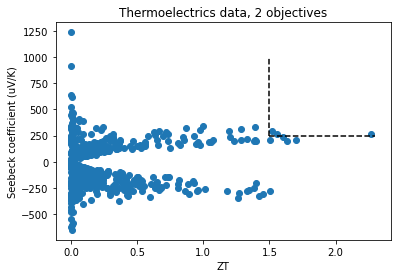

In [100]:
x = outputs["ZT"]
y = outputs["Seebeck"]
plt.scatter(df[x], df[y])
plt.xlabel(x)
plt.ylabel(y)
plt.hlines(250.0, xmin=1.5, xmax=2.3, linestyles='dashed', colors='k')
plt.vlines(1.5, ymin=250.0, ymax=1000.0, linestyles='dashed', colors='k')
plt.title("Thermoelectrics data, 2 objectives")
plt.show()

Train models to predict Seebeck coefficient and ZT as a function of chemical composition and temperature (we'll also use crystallinity in Lolo, but Scikit-learn does not natively accept categorical input features for random forests).
Use Matminer to featurize the chemical formulae.

In [101]:
df = StrToComposition().featurize_dataframe(df, "formula")

StrToComposition:   0%|          | 0/688 [00:00<?, ?it/s]

In [102]:
featurized_df = ElementProperty.from_preset(preset_name="magpie").featurize_dataframe(df, col_id="composition")

ElementProperty:   0%|          | 0/688 [00:00<?, ?it/s]

In [103]:
excluded = ["formula", "composition"]
ml_df = featurized_df.drop(excluded, axis=1)

In [104]:
ml_df

,Crystallinity,Temperature (K),log Resistivity,Power factor (W*m/K^2),ZT,Thermal conductivity (W/(m*K)),Seebeck coefficient (uV/K),MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,polycrystalline,300.000112,-3.112946,0.001100,0.039442,8.35000,-92.0000,28.0,51.0,23.0,...,0.595395,0.198465,0.264620,0.595395,141.0,225.0,84.0,187.000000,30.000000,225.0
1,polycrystalline,1000.000131,-2.680555,0.000661,0.262892,2.51443,-117.4440,8.0,49.0,41.0,...,0.000000,0.000000,0.000000,0.000000,12.0,225.0,213.0,64.520000,63.024000,12.0
2,polycrystalline,1000.000171,-1.669586,0.000022,0.006710,3.22000,-68.0000,8.0,39.0,31.0,...,2.110663,0.638052,0.890133,0.000000,12.0,229.0,217.0,214.416919,24.028132,227.0
3,polycrystalline,1000.000171,-2.284888,0.000178,0.096460,1.84140,-96.0071,8.0,83.0,75.0,...,0.000310,0.000062,0.000099,0.000000,12.0,225.0,213.0,91.340000,98.381600,12.0
4,polycrystalline,300.000130,-3.160909,0.000108,0.022592,1.43230,27.2882,16.0,42.0,26.0,...,0.000310,0.000026,0.000048,0.000000,70.0,229.0,159.0,144.843137,78.267333,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,polycrystalline,700.000872,-2.202382,0.000044,0.020260,1.51492,-52.4500,8.0,39.0,31.0,...,0.000310,0.000062,0.000099,0.000000,12.0,225.0,213.0,93.740000,98.088000,12.0
684,polycrystalline,1000.000213,-0.956358,0.000150,0.089159,1.67874,-406.8100,8.0,25.0,17.0,...,0.000310,0.000062,0.000099,0.000000,12.0,225.0,213.0,95.600000,100.320000,12.0
685,polycrystalline,300.000489,-2.907199,0.000064,0.006251,3.08340,-28.2100,8.0,74.0,66.0,...,0.000000,0.000000,0.000000,0.000000,12.0,229.0,217.0,67.641026,82.748192,12.0
686,polycrystalline,400.000598,-4.009425,0.000649,0.033229,7.81700,-25.2100,8.0,74.0,66.0,...,0.000000,0.000000,0.000000,0.000000,12.0,229.0,217.0,70.301988,85.275665,12.0


In the 4-objective problem, the resulting multivariate normal distribution often results in a singular matrix exception because the different dimensions vary by orders of magnitude. I therefore rescale the power factor, ZT, and Seebeck coefficient so that they are all on the order of ~10

In [105]:
ml_df_rescaled = ml_df.copy()
for key, multiplicative_factor in [
    ("Power factor (W*m/K^2)", 1e4),
    ("ZT", 1e1),
    ("Seebeck coefficient (uV/K)", 1e-2)
]:
    ml_df_rescaled[key] = ml_df[key] * multiplicative_factor

Write featurized data to csv, for use in Lolo.

In [108]:
ml_df.to_csv("src/main/resources/thermoelectrics_clean.csv", sep=",", index=False)

In [109]:
ml_df_rescaled.to_csv("src/main/resources/thermoelectrics_clean_rescaled.csv", sep=",", index=False)

In [110]:
categoricals = ["Crystallinity"]
y_zt = ml_df["ZT"].values
X = ml_df.drop(list(outputs.values()), axis=1).drop(categoricals, axis=1)
rf_zt = RandomForestRegressor(n_estimators=64, random_state=17)
rf_zt.fit(X, y_zt)

RandomForestRegressor(n_estimators=64, random_state=17)

In [111]:
categoricals = ["Crystallinity"]
y_sb = ml_df["Seebeck coefficient (uV/K)"].values
X = ml_df.drop(list(outputs.values()), axis=1).drop(categoricals, axis=1)
rf_sb = RandomForestRegressor(n_estimators=64, random_state=17)
rf_sb.fit(X, y_sb)

RandomForestRegressor(n_estimators=64, random_state=17)

Check out the results of 10-fold cross-validation, to verify that there is signal.

In [112]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [113]:
y_zt_pred = cross_val_predict(rf_zt, X, y_zt, cv=crossvalidation)

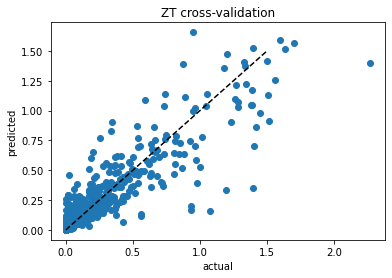

In [114]:
plt.scatter(y_zt, y_zt_pred)
plt.plot([0, 1.5], [0, 1.5], 'k--')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("ZT cross-validation")
plt.show()

In [115]:
y_sb_pred = cross_val_predict(rf_sb, X, y_sb, cv=crossvalidation)

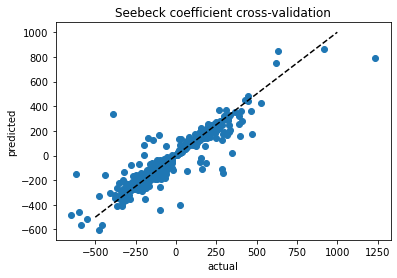

In [116]:
plt.scatter(y_sb, y_sb_pred)
plt.plot([-500, 1000], [-500, 1000], 'k--')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("Seebeck coefficient cross-validation")
plt.show()